In [29]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

plt.rcParams.update({'figure.max_open_warning': 200})
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
from numpy import array
from matplotlib import cm
from sklearn import preprocessing

from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

In [30]:
pd.set_option( "display.max_columns", None)

data  = pd.read_csv("credit.csv") 

# How big is the training dataset?
a look at the data set

In [34]:
print("The  dataset has {} entires or columns.".format(data.shape))

The  dataset has (5960, 13) entires or columns.


# lets see each sample of our target label

In [35]:
data_sample1 = data.loc[data.BAD==1].sample(frac=0.1, replace=False)
print('label 1 sample size:', str(data_sample1.shape[0]))
data_sample0 = data.loc[data.BAD==0].sample(frac=0.1, replace=False)
print('label 0 sample size:', str(data_sample0.shape[0]))
sample = pd.concat([data_sample1, data_sample0], axis=0)

label 1 sample size: 119
label 0 sample size: 477


# let see the numbers of categorical features and numerical features

In [33]:
categorical_list = []
numerical_list = []
for i in data.columns.tolist():
    if data[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 2
Number of numerical features: 11


In [37]:
data.sample(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
4703,1,24800,76220.0,102087.0,HomeImp,Mgr,6.0,0.0,1.0,126.641020,0.0,32.0,48.569574
987,0,9300,21979.0,39880.0,DebtCon,Other,3.0,NaN,NaN,NaN,NaN,NaN,38.844089
4811,0,25100,108235.0,201918.0,DebtCon,Other,24.0,0.0,0.0,199.486464,0.0,19.0,23.652340
2513,0,14900,72637.0,103297.0,DebtCon,Other,4.0,2.0,0.0,83.466086,0.0,20.0,22.553040
2440,0,14600,82837.0,95796.0,DebtCon,Other,0.0,0.0,0.0,148.355221,0.0,23.0,42.033085


In [38]:
data.BAD.value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

# data cleaning

In [39]:
#lets find the count of null values

data.isnull().sum().sort_values(ascending=False)

DEBTINC    1267
DEROG       708
DELINQ      580
MORTDUE     518
YOJ         515
NINQ        510
CLAGE       308
JOB         279
REASON      252
CLNO        222
VALUE       112
LOAN          0
BAD           0
dtype: int64

In [40]:
#lets put all the variables with missing values and their percentage in a table

def missing_values_table(df):
    missing_values= df.isnull().sum()
    
    # Percentage of missing values
    
    missing_percentage = 100 *df.isnull().sum() /len(df)
    
    missing_values_table = pd.concat([missing_values, missing_percentage],axis=1)
    
    missing_val_table_columns = missing_values_table.rename(columns={0 : 'Missing Values', 1 : '% of Missing Values'})
    
    missing_val_table_columns = missing_val_table_columns[
            missing_val_table_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)
    
    return missing_val_table_columns



# Lets see the missing value table
missing_values_table(data)

,Missing Values,% of Missing Values
DEBTINC,1267,21.3
DEROG,708,11.9
DELINQ,580,9.7
MORTDUE,518,8.7
YOJ,515,8.6
NINQ,510,8.6
CLAGE,308,5.2
JOB,279,4.7
REASON,252,4.2
CLNO,222,3.7


In [41]:
(missing_values_table(data)).head(49)

,Missing Values,% of Missing Values
DEBTINC,1267,21.3
DEROG,708,11.9
DELINQ,580,9.7
MORTDUE,518,8.7
YOJ,515,8.6
NINQ,510,8.6
CLAGE,308,5.2
JOB,279,4.7
REASON,252,4.2
CLNO,222,3.7


In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing



# lets encode our categorical data

In [43]:
credit_encode = data
encoder=LabelEncoder()

In [44]:
credit_encode['REASON'] = encoder.fit_transform(credit_encode['REASON'])
credit_encode['JOB'] = encoder.fit_transform(credit_encode['JOB'])


In [45]:
data.fillna((0), inplace=True)

In [46]:
data.shape

(5960, 13)

In [47]:
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,1,2,10.5,0.0,0.0,94.366667,1.0,9.0,0.0
1,1,1300,70053.0,68400.0,1,2,7.0,0.0,2.0,121.833333,0.0,14.0,0.0
2,1,1500,13500.0,16700.0,1,2,4.0,0.0,0.0,149.466667,1.0,10.0,0.0
3,1,1500,0.0,0.0,2,6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0,1700,97800.0,112000.0,1,1,3.0,0.0,0.0,93.333333,0.0,14.0,0.0


# Feature Selection
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Three benefits of performing feature selection before modeling your data are:

Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise. Improves Accuracy: Less misleading data means modeling accuracy improves. Reduces Training Time: Less data means that algorithms train faster.

In [ ]:
X = data.drop('BAD', axis = 1)
y = data.BAD

In [49]:
X.shape, y.shape

((5960, 12), (5960,))

# Univariate Feature Selection
Univariate feature selection selects the best features by running univariate statistical tests like chi-squared test, F-1 test, and mutual information methods.

In [50]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [51]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [52]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   features         Score
2     VALUE  1.596433e+06
1   MORTDUE  3.674824e+05
0      LOAN  2.268599e+05
11  DEBTINC  9.801855e+03
8     CLAGE  7.914209e+03
7    DELINQ  2.054126e+03
6     DEROG  1.233862e+03
9      NINQ  4.698772e+02
5       YOJ  5.762630e+01
10     CLNO  4.071969e+00


# Recursive Feature Elimination (RFE)
Recursive Feature Elimination (RFE) recursively selects important subsets of features based on built-in attributes like coefficients or feature importance of a given estimator. Hence RFE heavily depends on which estimator we are using.

In [53]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [61]:
def print_best_worst (scores):
    scores = sorted(scores, reverse = True)
    
    print("The 5 best features selected by this method are :")
    for i in range(5):
        print(scores[i][1])
    
    print ("The 5 worst features selected by this method are :")
    for i in range(5):
        print(scores[len(scores)-1-i][1])

In [62]:
clf = RandomForestClassifier(n_estimators = 50, max_depth = 4)

scores = []
num_features = len(X.columns)
for i in range(num_features):
    col = X.columns[i]
    score = np.mean(cross_val_score(clf, X[col].values.reshape(-1,1), y, cv=10))
    scores.append((int(score*100), col))

print(sorted(scores, reverse = True))

[(86, 'DEBTINC'), (81, 'VALUE'), (81, 'DELINQ'), (80, 'YOJ'), (80, 'REASON'), (80, 'MORTDUE'), (80, 'JOB'), (80, 'DEROG'), (80, 'CLNO'), (80, 'CLAGE'), (79, 'NINQ'), (24, 'LOAN')]


In [63]:

rfe = RFE(LogisticRegression(), n_features_to_select=1)
rfe.fit(X,y)


RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [64]:
scores = []
for i in range(num_features):
    scores.append((rfe.ranking_[i],X.columns[i]))
    
print_best_worst(scores)



The 5 best features selected by this method are :
VALUE
MORTDUE
LOAN
CLNO
CLAGE
The 5 worst features selected by this method are :
DELINQ
DEROG
REASON
NINQ
DEBTINC


# Feature Importance
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

In [65]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [66]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers


[0.07094769 0.06828143 0.09203056 0.03084326 0.05749234 0.0646336
 0.05805875 0.09377093 0.08296704 0.05506822 0.07313018 0.252776  ]


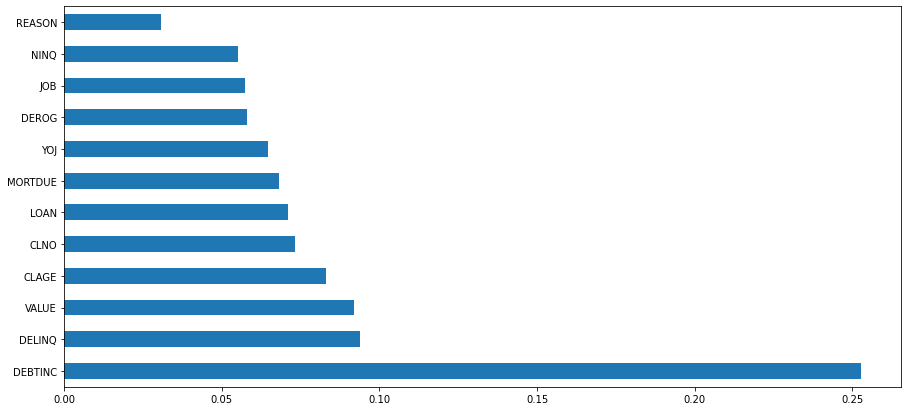

In [67]:
#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(15,7))

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

# let try Random Forest Feature Importance

In [68]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X,y)

RandomForestClassifier()

In [69]:
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers


[0.07451879 0.07105862 0.10987375 0.01468511 0.03558381 0.05706483
 0.0416858  0.0825885  0.09193231 0.03558877 0.06456309 0.32085663]


In [70]:
scores = []
for i in range(num_features):
    scores.append((clf.feature_importances_[i],X.columns[i]))
        
print_best_worst(scores)

The 5 best features selected by this method are :
DEBTINC
VALUE
CLAGE
DELINQ
LOAN
The 5 worst features selected by this method are :
REASON
JOB
NINQ
DEROG
YOJ


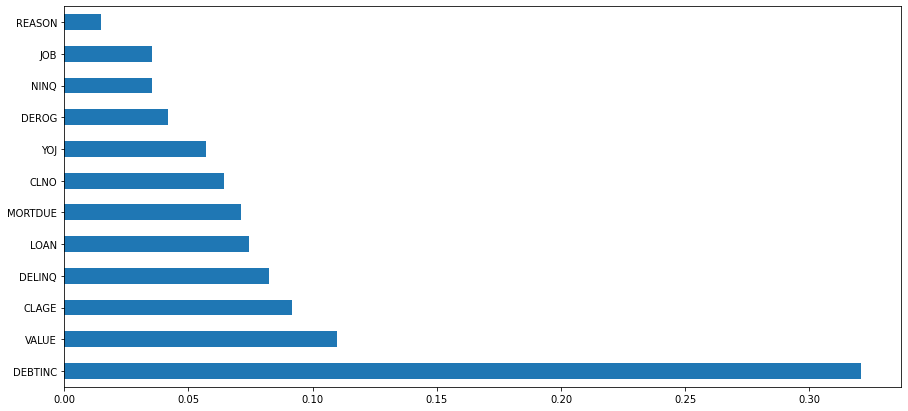

In [71]:
#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(15,7))

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

# Correlation Matrix with Heatmap
Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

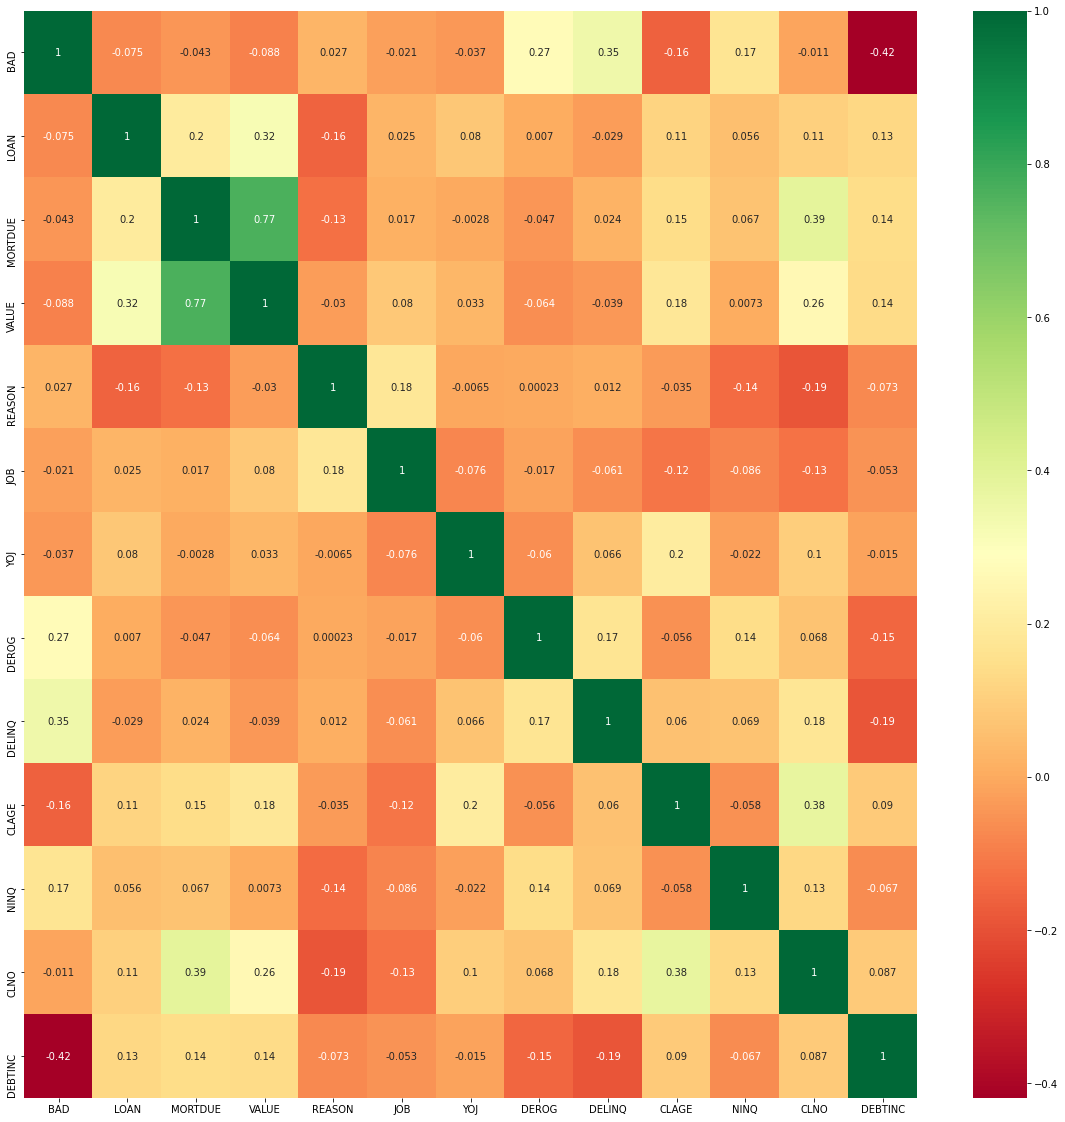

In [72]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index                                    
plt.figure(figsize=(20,20))                                  
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# predictive analysis

In [73]:
from pandas import Series,DataFrame
from numpy.random import randn
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE  

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


import math
from sklearn import tree

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE   # Recursive Feature Elimination
from sklearn.svm import SVR                 # Support Vector Regression
import sklearn
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.feature_selection import RFE   # Recursive Feature Elimination
from sklearn.svm import SVR                 # Support Vector Regression
from sklearn.svm import SVC

from matplotlib import pyplot
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std


In [74]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection


In [75]:
# Scale the data to be between -1 and 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X)

array([[-2.66117655,  0.12294865,  0.07816407, ...,  0.05685096,
        -0.14581657, -0.11917353],
       [-1.65309673,  0.68832074,  0.6130007 , ...,  0.16817819,
         0.12192226, -0.32729149],
       [-2.85699206,  0.23422018,  0.0084693 , ...,  0.71639466,
         0.00655473, -0.22306989],
       ...,
       [ 1.9150773 , -1.00091997, -0.82605131, ...,  2.17670091,
        -0.95306862, -0.74633815],
       [ 1.89610902, -0.95557133, -0.78630123, ...,  2.29394562,
        -1.03754677, -0.69938867],
       [ 1.89193655, -0.91558079, -0.89268341, ...,  2.25718065,
        -1.02377309, -0.71925012]])

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

# first, let see how each of our models will perform before stacking

In [146]:

# the list of models to evaluate
def get_models():
    models = dict()
    models['lr']           = LogisticRegression()
    models['svm']          = SVC()
    models['k_nbor']        = KNeighborsClassifier()
    models['r_forest_clas'] = RandomForestClassifier(random_state=1)
    models['dtree']         = DecisionTreeClassifier()
    models['g_nb']          = GaussianNB()

                         
    return models

In [147]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

now, We can then report the mean performance of each algorithm and also create a box and whisker plot to compare the distribution of accuracy scores for each algorithm.

>lr 0.871 (0.012)
>svm 0.904 (0.009)
>k_nbor 0.891 (0.010)
>r_forest_clas 0.913 (0.008)
>dtree 0.876 (0.014)
>g_nb 0.836 (0.013)


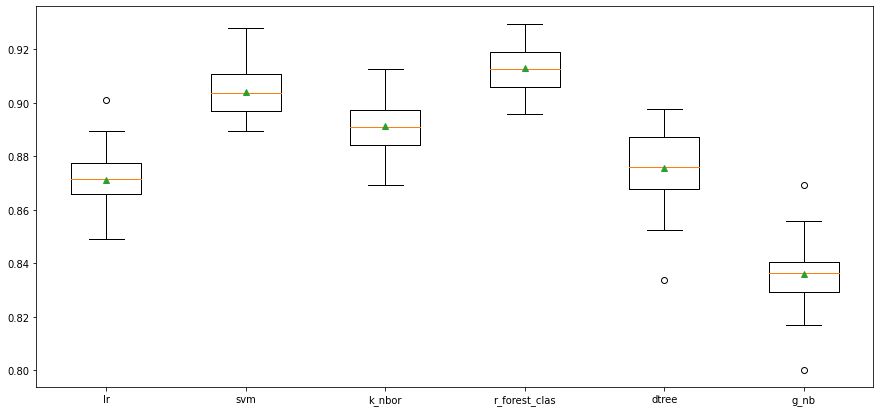

In [148]:

# get the models to evaluate
models = get_models()


# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
    
    
# plot model performance for comparison
fig, ax = plt.subplots(figsize=(15,7))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Stacking models

Now that we have defined all of our models, we can begin improving our results by stacking the models.

In [149]:
# Initializing models



k_nbor        = KNeighborsClassifier(n_neighbors=1)
r_forest_clas = RandomForestClassifier(random_state=1)
dtree         = DecisionTreeClassifier()
g_nb          = GaussianNB()
svm           = SVC()
lr            = LogisticRegression()



sclf = StackingClassifier(classifiers=[k_nbor, r_forest_clas, dtree,  g_nb, svm, ], 
                          meta_classifier=lr) 





#hyperparameters tunning / gridsearchcv

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)


grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.904 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.907 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.902 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.906 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.889 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.902 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.866 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.865 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [150]:
y_pred = grid.predict(X_test)


In [151]:
print("Testing Accuracy :", grid.score(X_test, y_test))
print("Training Accuracy :", grid.score(X_train,y_train)) 

Testing Accuracy : 0.9060402684563759
Training Accuracy : 1.0


# confusion_matrix

In [152]:
from sklearn.metrics import confusion_matrix

Y_pred = grid.predict(X_test)
Y_pred = [ 1 if y>=0.5 else 0 for y in Y_pred]

In [153]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
print(cm)

[[928  32]
 [ 80 152]]


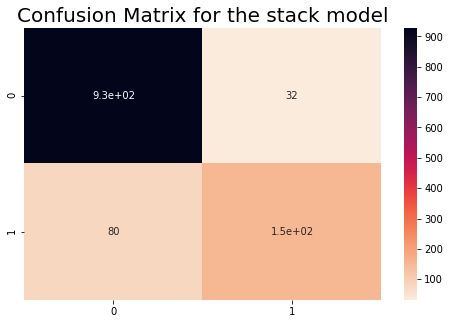

In [154]:
# plottinhg the confusion matrix

plt.rcParams['figure.figsize'] = (8, 5)
sns.heatmap(cm, annot = True, cmap = 'rocket_r')
plt.title('Confusion Matrix for the stack model', fontweight = 30, fontsize = 20)
plt.show()

# stack model classification report

In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       960
           1       0.83      0.66      0.73       232

    accuracy                           0.91      1192
   macro avg       0.87      0.81      0.84      1192
weighted avg       0.90      0.91      0.90      1192



# Optimal Probability Thresholds with ROC Curve

In [156]:
stack_model_prob = grid.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(stack_model_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
grid.score(X_test, y_pred)

1.0

In [157]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, stack_model_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9001504130747127

Text(0.5, 0, 'False Positive Rate')

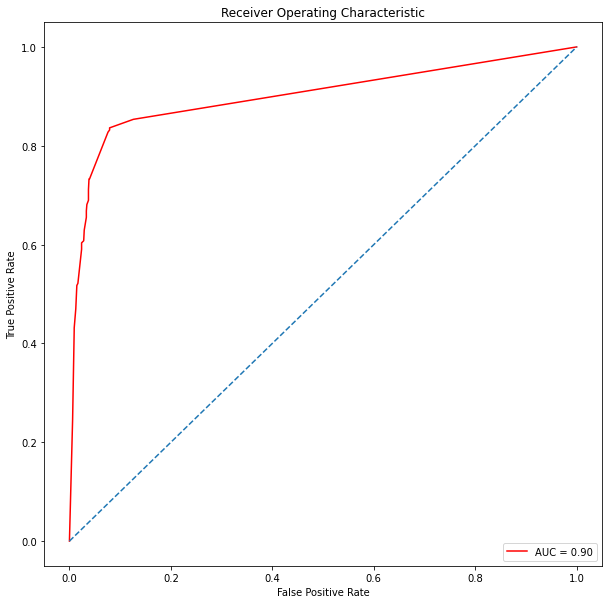

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# when you have a better model prediction

In [165]:
from IPython.display import Video

Video("GIF.mp4")